# Multi-Class GALE - Wine Quality Dataset with LIME

In [1]:
import numpy as np
np.random.seed(1000)

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

from lime.lime_tabular import LimeTabularExplainer

from gale import create_mapper, mapper_to_networkx
from metricmapper.metricmapper import *

## 1. Get and split data

In [2]:
df = pd.read_csv('data/winequality-red.csv')
X = df.drop('quality', axis=1)
y = df['quality']
classes = np.unique(y)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [4]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 2. Train model

In [5]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 64), batch_size=32, random_state=2023, max_iter=10000)
mlp.fit(X_train, y_train)

predictions = mlp.predict_proba(X_test)

print(classification_report(y_test, mlp.predict(X_test)))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.14      0.06      0.09        16
           5       0.65      0.81      0.72       204
           6       0.62      0.47      0.54       192
           7       0.51      0.58      0.54        60
           8       0.00      0.00      0.00         5

    accuracy                           0.61       480
   macro avg       0.32      0.32      0.31       480
weighted avg       0.59      0.61      0.59       480



/home/pari/miniconda3/envs/mountaineer/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pari/miniconda3/envs/mountaineer/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pari/miniconda3/envs/mountaineer/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## 3. Generate explanations

In [6]:
def run_lime(X, model, num_classes, num_features=4, num_samples=100):
    labels = [i for i in range(num_classes)]
    explainer = LimeTabularExplainer(X, discretize_continuous=False)
    lime_exp = [[] for i in range(num_classes)]
    for x in X:
        exp = explainer.explain_instance(x, model.predict_proba, num_features=num_features, 
                                         num_samples=num_samples, labels=labels)
        for i in range(num_classes):
            tmp = [0 for i in range(X.shape[1])]
            for e in exp.as_list(label=i):
                tmp[int(e[0])] = e[1]
            lime_exp[i].append(tmp)
    lime_exp = np.array(lime_exp)
    return lime_exp

In [7]:
lime_exp = run_lime(X_test, mlp, num_classes=len(classes))

## 4. Mapper for each class

Get distance threshold parameter for the feature space and the explanation space of every feature:

In [8]:
delta_feat = estimate_scale(X_test, 100)
print(f"Delta features: {delta_feat}")

delta_lime = []
for i in range(lime_exp.shape[0]):
    delta_lime.append(estimate_scale(lime_exp[i,:], 100))

print(f"Deltas lime: {delta_lime}")

resolution = 5
gain = 0.5

Delta features: 0.7571524102371767
Deltas lime: [0.04494365101632898, 0.057534121359929975, 0.1479884835704177, 0.1223707858790975, 0.10493729523065166, 0.029477286826820097]


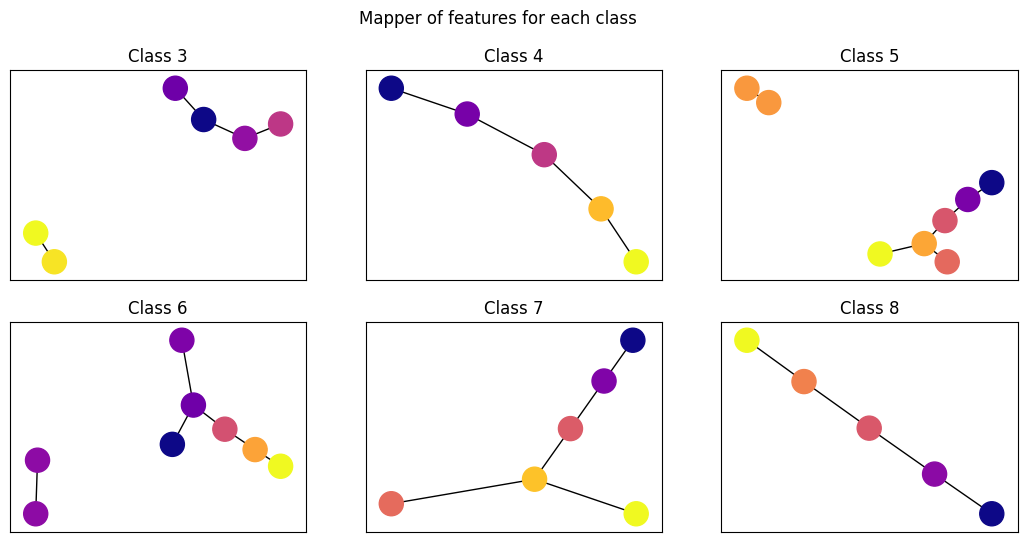

In [9]:
mapper_classes = []

fig, axs = plt.subplots(2, 3, figsize=(13, 6))
fig.suptitle('Mapper of features for each class')

for i in range(len(classes)):
    mapper = create_mapper(X_test, predictions[:,i], resolution=resolution, gain=gain, dist_thresh=delta_feat/(X_test.max() - X_test.min()))
    mapper_classes.append(mapper)

    G = mapper_to_networkx(mapper)
    colors = list(nx.get_node_attributes(G, "avg_pred").values())

    jx = i%3
    ix = i//3
    nx.draw_networkx(G, ax=axs[ix, jx], with_labels=False, node_color=colors, cmap=plt.cm.plasma)
    axs[ix, jx].set_title('Class '+str(classes[i]))

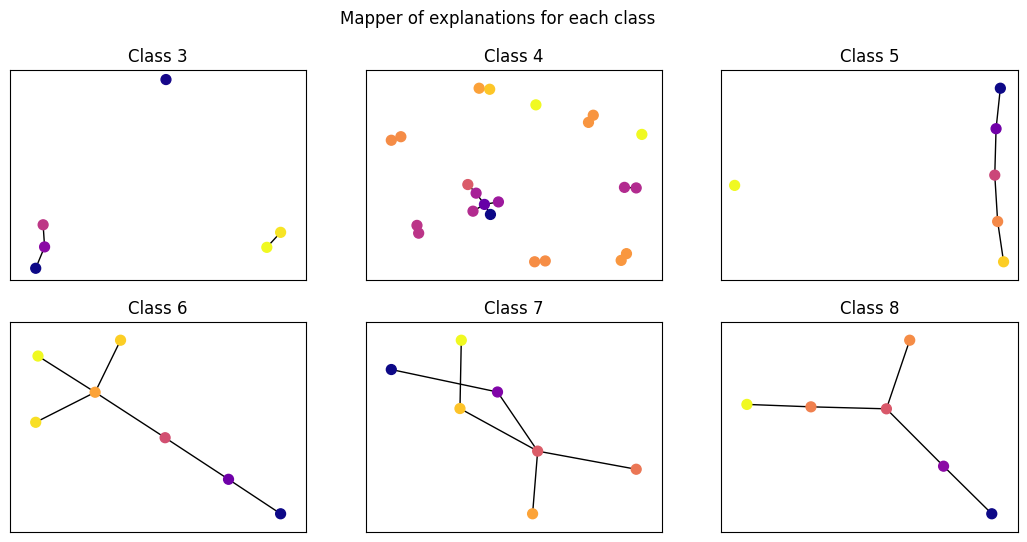

In [10]:
mapper_classes = []

fig, axs = plt.subplots(2, 3, figsize=(13, 6))
fig.suptitle('Mapper of explanations for each class')

for i in range(len(classes)):
    mapper = create_mapper(lime_exp[i,:], predictions[:,i], resolution=resolution, gain=gain,
                           dist_thresh=delta_lime[i]/(lime_exp[i,:].max() - lime_exp[i,:].min()))
    mapper_classes.append(mapper)

    G = mapper_to_networkx(mapper)
    colors = list(nx.get_node_attributes(G, "avg_pred").values())

    jx = i%3
    ix = i//3
    nx.draw_networkx(G, ax=axs[ix, jx], with_labels=False, node_color=colors, cmap=plt.cm.plasma, node_size=50)
    axs[ix, jx].set_title(f'Class {classes[i]}')

## 5. Mapper for all classes

In [11]:
delta_lime = []
for i in range(lime_exp.shape[0]):
    delta_lime.append(estimate_scale(lime_exp[i,:], 100))
resolution = 5

cover = HypercubeCover(cover_mode="implicit", 
                       bnds=np.array([[0.,1.] for i in range(len(classes))]), 
                       resolutions=np.array([resolution for i in range(len(classes))]), 
                       gains=np.array([gain for i in range(len(classes))]))

The mapper has 152 vertices.


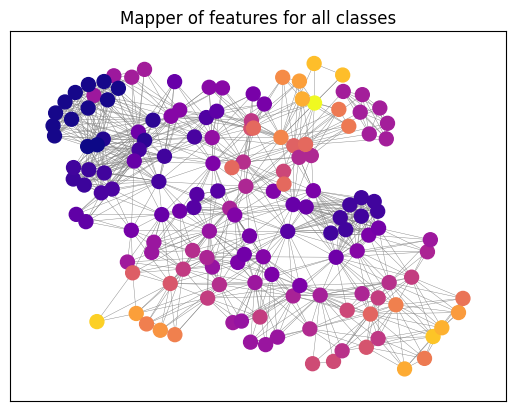

In [17]:
mapper = MetricMapperComplex(filters=predictions, colors=predictions, codomain="vectors", 
                            cover=cover,
                            clustering=AgglomerativeClustering(n_clusters=None, 
                                                               linkage="single", 
                                                               distance_threshold=delta_feat)
                            ).fit(X_test)

print(f"The mapper has {mapper.mapper_.num_vertices()} vertices.")

G = mapper2networkx(mapper)
plt.figure()
nx.draw_networkx(G, with_labels=False, pos=nx.kamada_kawai_layout(G), 
                 node_color=[np.var(mapper.node_info_[name]["colors"]) for name in G.nodes()],
                 cmap=plt.cm.plasma, node_size=100, edge_color="gray", width=0.3)
plt.title("Mapper of features for all classes")
plt.show()

Class 3: 139 vertices
Class 4: 234 vertices
Class 5: 205 vertices
Class 6: 199 vertices
Class 7: 190 vertices
Class 8: 141 vertices


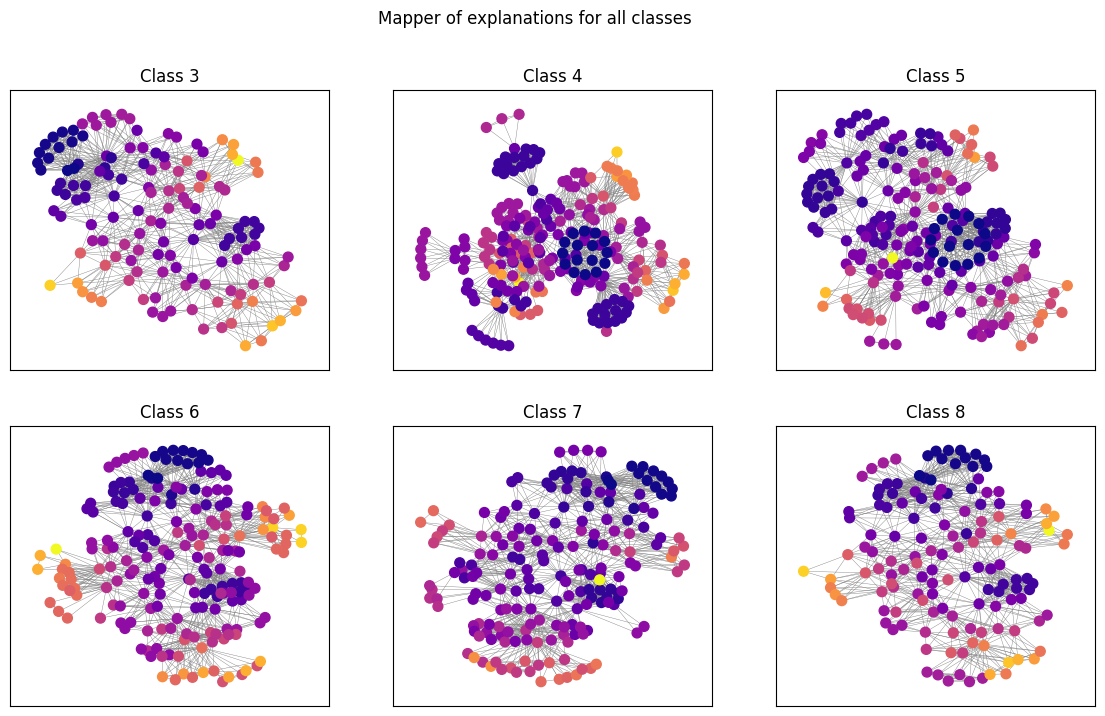

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('Mapper of explanations for all classes')

for i in range(6):
    mapper = MetricMapperComplex(filters=predictions, colors=predictions, codomain="vectors", 
                                cover=cover,
                                clustering=AgglomerativeClustering(n_clusters=None, 
                                                                linkage="single", 
                                                                distance_threshold=delta_lime[i])
                                ).fit(lime_exp[i,:])

    print(f"Class {classes[i]}: {mapper.mapper_.num_vertices()} vertices")

    jx = i%3
    ix = i//3

    G = mapper2networkx(mapper)
    nx.draw_networkx(G, with_labels=False, pos=nx.kamada_kawai_layout(G), 
                    node_color=[np.var(mapper.node_info_[name]["colors"]) for name in G.nodes()],
                    cmap=plt.cm.plasma, ax=axs[ix,jx], node_size=50, edge_color="gray", width=0.3)
    axs[ix,jx].set_title(f'Class {classes[i]}')

plt.show()

In [29]:
G.edges

EdgeView([(0, 3), (0, 6), (0, 8), (0, 11), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 21), (0, 23), (0, 28), (0, 44), (0, 45), (0, 46), (0, 48), (0, 56), (0, 57), (0, 58), (0, 59), (0, 78), (0, 79), (0, 88), (0, 92), (0, 93), (3, 6), (3, 8), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 21), (3, 23), (3, 53), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (3, 63), (3, 69), (6, 2), (6, 5), (6, 8), (6, 10), (6, 19), (6, 20), (6, 22), (6, 28), (6, 29), (6, 30), (6, 44), (6, 45), (6, 46), (6, 48), (6, 49), (6, 50), (6, 52), (6, 58), (6, 79), (6, 92), (6, 93), (6, 126), (6, 127), (6, 144), (11, 12), (11, 13), (11, 14), (11, 15), (11, 16), (11, 17), (11, 18), (11, 19), (11, 21), (11, 23), (11, 31), (11, 34), (11, 53), (11, 54), (11, 55), (11, 56), (11, 57), (11, 58), (11, 59), (11, 60), (11, 63), (11, 68), (11, 69), (11, 76), (11, 128), (11, 129), (11, 147), (11, 148), (14, 15), (14, 16), (14, 17), (14, 18), (14, 19), (14, 21), (14, 23), (1

In [31]:
mapper.node_info_

{0: {'indices': array([  0,   2,   7,  13,  16,  19,  26,  33,  34,  35,  36,  40,  42,
          43,  46,  48,  49,  53,  57,  58,  64,  69,  73,  77,  79,  82,
          83,  88,  95,  96,  97, 102, 103, 106, 108, 124, 125, 127, 128,
         130, 133, 135, 141, 147, 148, 151, 162, 164, 170, 172, 174, 177,
         181, 185, 186, 193, 194, 200, 205, 210, 216, 220, 224, 231, 239,
         240, 242, 243, 247, 255, 257, 260, 263, 272, 273, 276, 277, 279,
         281, 286, 287, 288, 296, 299, 304, 307, 310, 321, 330, 347, 349,
         353, 359, 360, 364, 370, 373, 378, 383, 389, 390, 395, 398, 403,
         407, 419, 423, 425, 429, 439, 447, 450, 455, 456, 457, 458, 462,
         467, 469, 470, 472, 474, 476]),
  'size': 123,
  'colors': array([2.46532522e-03, 4.55703553e-02, 5.59135554e-01, 3.42202540e-01,
         5.05300033e-02, 9.62226961e-05]),
  'patch': (0, 0, 2, 1, 0, 0)},
 1: {'indices': array([261]),
  'size': 1,
  'colors': array([1.77676219e-07, 4.78985594e-03, 6.60182132e-

In [36]:
from collections import defaultdict
mapper_obj = {}
nodes_dict = defaultdict(list)

for node, data in mapper.node_info_.items():
    indices = data['indices']
    nodes_dict[str(node)].extend(indices)
    
edges_dict = defaultdict(list)

for edge in G.edges:
    source, target = str(edge[0]), str(edge[1])
    edges_dict[source].append(target)

mapper_obj['links'] = edges_dict
mapper_obj['nodes'] = nodes_dict

In [37]:
mapper_obj

{'links': defaultdict(list,
             {'0': ['3',
               '6',
               '8',
               '11',
               '14',
               '15',
               '16',
               '17',
               '18',
               '19',
               '21',
               '23',
               '28',
               '44',
               '45',
               '46',
               '48',
               '56',
               '57',
               '58',
               '59',
               '78',
               '79',
               '88',
               '92',
               '93'],
              '3': ['6',
               '8',
               '11',
               '12',
               '13',
               '14',
               '15',
               '16',
               '17',
               '18',
               '19',
               '21',
               '23',
               '53',
               '55',
               '56',
               '57',
               '58',
               '59',
               '63',
